In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load pre-processed Perturbseq experiment from hdf5

Populations are constructed in notebook *GI generate populations*

In [2]:
pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/final_single_cell_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 30.5189180374s.
Done.


In [3]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: int32(24665)
memory usage: 8.6 GB

Normalized matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: float64(24665)
memory usage: 17.2 GB


In [4]:
control_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/control_pop.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 2.51185178757s.
Done.


In [5]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.18722319603s.
Done.


# Load emap information

In [6]:
# these have different names in the emap and in GChr38
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

inverse_name_replacer = {v: k for k, v in name_replacer.iteritems()}

In [7]:
emap = pd.read_csv('./final_emaps/processed_emap.csv', index_col=[0])
phen_matrix = pd.read_csv('./final_emaps/processed_fitnesses.csv', index_col=[0])
single_phen = pd.read_csv('./final_emaps/single_fitnesses.csv', index_col=[0])

In [8]:
# this is average fitness across two guides in primary emap, not single guide used for perturbseq
single_fitnesses = single_phen['average_fitness']

# fitness mapper, maps names to raw fitness values
fitness_mapper = dict()
for perturbation in pop.cells['guide_target'].unique():
    first, second = perturbation.split('_')
    try:
        if 'NegCtrl' in second:
            fitness_mapper[perturbation] = single_fitnesses.loc[first]
        elif 'NegCtrl' in first:
            fitness_mapper[perturbation] = single_fitnesses.loc[second]
        else:
            fitness_mapper[perturbation] = phen_matrix.loc[first, second]
    except KeyError:
        fitness_mapper[perturbation] = np.nan

In [9]:
single_genes = np.intersect1d(reduce(np.union1d, mean_pop.cells.query('num_targets == 1')['guide_target'].map(lambda x: x.split('_'))),
               emap.columns.map(lambda x: name_replacer.get(x, x)))
# we know these don't work...
single_genes = np.setdiff1d(single_genes, ['BAK1', 'BCL2L11'])

# maps gene name to single (SLC38A2 is the lone exception where we don't have it in position 1)
single_gene_perturbations = dict()

for gene in single_genes:
    if gene + '_NegCtrl0' in mean_pop.cells.index:
        single_gene_perturbations[gene] = gene + '_NegCtrl0'
    elif 'NegCtrl0_' + gene in mean_pop.cells.index:
        single_gene_perturbations[gene] = 'NegCtrl0_' + gene
        
double_perturbations = mean_pop.cells.query('num_targets == 2').index
perturbations = single_gene_perturbations.values()

for p in double_perturbations:
    gene1, gene2 = p.split('_')
    if gene1 in single_genes and gene2 in single_gene_perturbations.keys():
        perturbations.append(p)
        
fitnesses = mean_pop.cells.loc[perturbations, 'fitness']

# add a negative control
perturbations = np.union1d(perturbations, 'NegCtrl0_NegCtrl0')
single_gene_perturbations['negative'] = 'NegCtrl0_NegCtrl0'
fitnesses['NegCtrl0_NegCtrl0'] = 0.0

mapper = {v: k for k, v in single_gene_perturbations.iteritems()}

# Technical performance

In [10]:
sns.set(font_scale=1.)

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

sns.set_style('white')

In [11]:
first_folds = mean_pop.cells[['control_first_expr', 'fold_first_expr']].replace({np.inf: np.nan, -np.inf: np.nan}).dropna()
second_folds = mean_pop.cells[['control_second_expr', 'fold_second_expr']].replace({np.inf: np.nan, -np.inf: np.nan}).dropna()

## Fold activation in each position

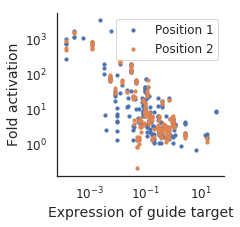

In [12]:
fig = plt.figure(figsize=[3, 3])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(first_folds['control_first_expr'], first_folds['fold_first_expr'], s=10, label='Position 1')
plt.scatter(second_folds['control_second_expr'], second_folds['fold_second_expr'], s=10, label='Position 2')
sns.despine()
plt.gca().legend()
plt.xlabel('Expression of guide target')
plt.ylabel('Fold activation')
plt.savefig('./figures/performance_fold_activation.pdf', bbox_inches='tight')

## Raw UMI difference in each position

In [13]:
first_deltas = mean_pop.cells[['control_first_expr', 'first_expr']].replace({np.inf: np.nan, -np.inf: np.nan}).dropna()
second_deltas = mean_pop.cells[['control_second_expr', 'second_expr']].replace({np.inf: np.nan, -np.inf: np.nan}).dropna()

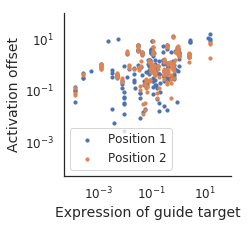

In [14]:
fig = plt.figure(figsize=[3,3])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(first_deltas['control_first_expr'], first_deltas['first_expr'] - first_deltas['control_first_expr'], s=10, label='Position 1')
plt.scatter(second_deltas['control_second_expr'], second_deltas['second_expr'] - second_deltas['control_second_expr'], s=10, label='Position 2')
sns.despine()
plt.gca().legend()
plt.xlim([5e-5, 100])
plt.ylim([5e-5, 100])
plt.xlabel('Expression of guide target')
plt.ylabel('Activation offset')
plt.savefig('./figures/performance_expression_difference.pdf', bbox_inches='tight')

## Differentially expressed genes vs. fitness

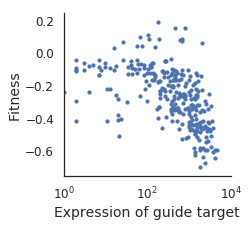

In [15]:
fig = plt.figure(figsize=[3,3])
ax = plt.gca()
ax.set_xscale('log')
# ax.set_yscale('log')
plt.scatter(mean_pop.cells['ks_de'].replace({-np.inf: 1}),
            mean_pop.cells['fitness'], s=10)
sns.despine()
#plt.gca().legend()
plt.xlim([1, 1e4])
#plt.ylim([5e-5, 2])
plt.xlabel('Expression of guide target')
plt.ylabel('Fitness')
plt.savefig('./figures/performance_de_genes_vs_fitness.pdf', bbox_inches='tight')

## Correlation of expression when guide is in position A or position B of cassette

In [16]:
# FOXF1 excluded because "infinite" induction
guides_both_positions = np.setdiff1d(np.intersect1d(mean_pop.cells['first_target'].unique(),
                                                    mean_pop.cells['second_target'].unique()),
                                     ['NegCtrl0', 'FOXF1', 'S1PR2'])

In [17]:
first_pos = guides_both_positions + '_NegCtrl0'
second_pos = 'NegCtrl0_' + guides_both_positions

In [18]:
both_expr =  mean_pop.where(cells=np.union1d(first_pos, second_pos),
              genes='mean > 0.25',
              normalized=False)
both_expr = np.log2(both_expr + 1)

In [19]:
from scipy.cluster.hierarchy import linkage
Z_corr = linkage(both_expr, metric='correlation', optimal_ordering=True)

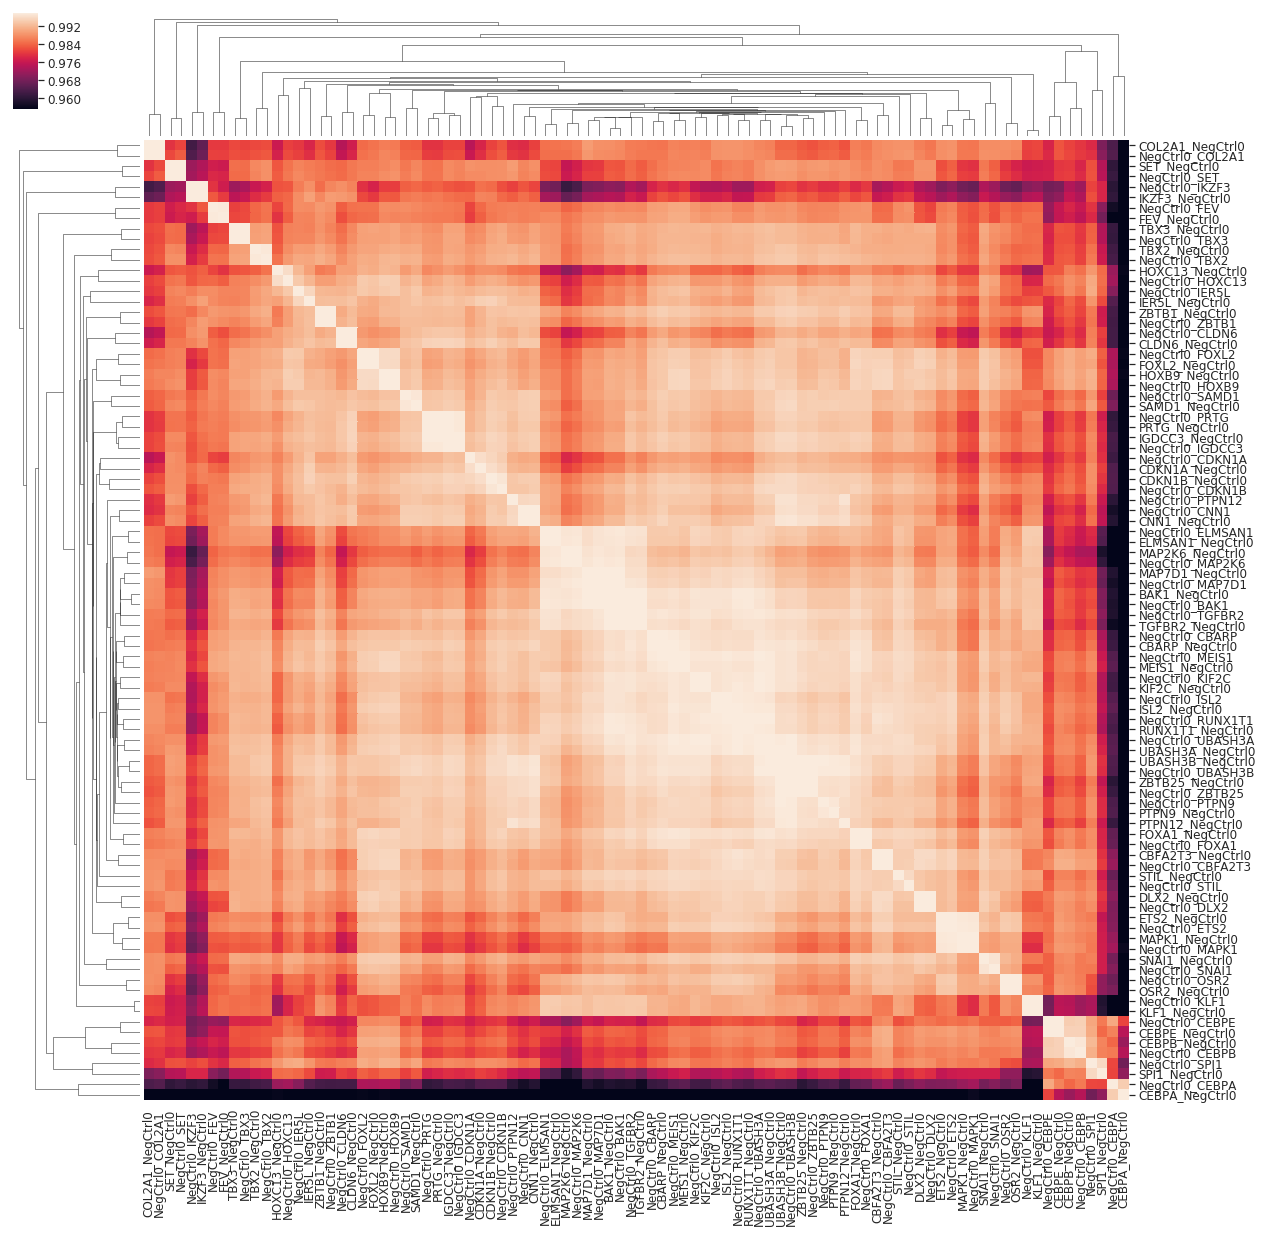

In [20]:
cg = sns.clustermap(both_expr.T.corr(),
               robust=True,
               row_linkage=Z_corr,
               col_linkage=Z_corr,
               figsize=[20, 20],
               xticklabels=True, yticklabels=True)
cg.savefig('./figures/performance_clustering_of_profiles.pdf')

## Downsample subpopulations containing guides in position A vs. position B to equal cell coverage

Necessary as otherwise there is bias towards detecting more differentially expressed genes in perturbations with greater representation.

In [21]:
cell_barcodes = list()

for guide in guides_both_positions:
    first = guide + '_NegCtrl0'
    second = 'NegCtrl0_' + guide
    
    first_sample = pop.cells.query('guide_target == @first')
    second_sample = pop.cells.query('guide_target == @second')
    
    n_first = first_sample.shape[0]
    n_second = second_sample.shape[0]
    
    if n_first > n_second:
        print('Downsampling {0} ({1}) to {2} ({3})'.format(first, n_first, second, n_second))
        first_sample = first_sample.sample(n=n_second, random_state=1000)
    else:
        print('Downsampling {0} ({1}) to {2} ({3})'.format(second, n_second, first, n_first))
        second_sample = second_sample.sample(n=n_first, random_state=1000)
        
    cell_barcodes.extend(first_sample.index.values)
    cell_barcodes.extend(second_sample.index.values)
    
cell_barcodes.extend(control_pop.cells.index.values)

Downsampling NegCtrl0_BAK1 (637) to BAK1_NegCtrl0 (534)
Downsampling CBARP_NegCtrl0 (480) to NegCtrl0_CBARP (270)
Downsampling CBFA2T3_NegCtrl0 (288) to NegCtrl0_CBFA2T3 (243)
Downsampling CDKN1A_NegCtrl0 (144) to NegCtrl0_CDKN1A (131)
Downsampling CDKN1B_NegCtrl0 (268) to NegCtrl0_CDKN1B (145)
Downsampling CEBPA_NegCtrl0 (322) to NegCtrl0_CEBPA (258)
Downsampling CEBPB_NegCtrl0 (240) to NegCtrl0_CEBPB (182)
Downsampling NegCtrl0_CEBPE (566) to CEBPE_NegCtrl0 (473)
Downsampling CLDN6_NegCtrl0 (281) to NegCtrl0_CLDN6 (263)
Downsampling NegCtrl0_CNN1 (400) to CNN1_NegCtrl0 (236)
Downsampling COL2A1_NegCtrl0 (247) to NegCtrl0_COL2A1 (227)
Downsampling DLX2_NegCtrl0 (316) to NegCtrl0_DLX2 (290)
Downsampling NegCtrl0_ELMSAN1 (430) to ELMSAN1_NegCtrl0 (353)
Downsampling NegCtrl0_ETS2 (656) to ETS2_NegCtrl0 (375)
Downsampling NegCtrl0_FEV (474) to FEV_NegCtrl0 (173)
Downsampling FOXA1_NegCtrl0 (426) to NegCtrl0_FOXA1 (335)
Downsampling FOXL2_NegCtrl0 (303) to NegCtrl0_FOXL2 (241)
Downsampling

Subsample to only selected cells

In [22]:
de_pop = pop.subpopulation(cells='index in @cell_barcodes',
                           genes='mean > 0.25',
                           normalized_matrix='inherit',
                           cell_barcodes=cell_barcodes)

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...


perturbseq/cell_population.py:369: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_pop.genes = new_pop.genes.loc[self.genes.index]


In [23]:
de_pop.genes = de_pop.genes.loc[pop.genes.query('mean > 0.25').index]
de_pop.genes['in_matrix'] = de_pop.genes['in_matrix'].astype(bool)

In [24]:
de_mean_pop = de_pop.average('guide_target', show_progress=True)

Computing average expression matrices...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Computing normalized average expression matrices...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Computing clusters...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Generating summary statistics...
Done.


Differentially expressed genes using KS test

In [25]:
sub_ks, sub_ps, sub_adj_ps = ks_de(de_pop,
                       key='guide_target',
                       control_cells='perturbed == "control"',
                       normalized=False,
                       alpha=0.001,
                       n_jobs=24)

7353 control cells
groupby: index in @key_barcodes (key = guide_target)


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    7.6s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   10.4s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   15.4s
[Parallel(n_jobs=24)]: Done  58 out of  95 | elapsed:   20.3s remaining:   13.0s
[Parallel(n_jobs=24)]: Done  68 out of  95 | elapsed:   23.1s remaining:    9.2s
[Parallel(n_jobs=24)]: Done  78 out of  95 | elapsed:   26.8s remaining:    5.8s
[Parallel(n_jobs=24)]: Done  88 out of  95 | elapsed:   28.6s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  95 out of  95 | elapsed:   30.6s finished


In [26]:
from collections import defaultdict

gene_epistasis = dict()
downsampled_stats = defaultdict(dict)

for guide in guides_both_positions:
    first = guide + '_NegCtrl0'
    second = 'NegCtrl0_' + guide
    print guide, pop.gene_ids(guide)
    de_genes_first = sub_adj_ps[first][sub_adj_ps[first] < 0.001].index.values
    de_genes_second = sub_adj_ps[second][sub_adj_ps[second] < 0.001].index.values
    de_union = np.union1d(de_genes_first, de_genes_second)
    de_intersection = np.intersect1d(de_genes_first, de_genes_second)
    downsampled_stats['jaccard'][guide] = float(len(de_intersection))/len(de_union)
    downsampled_stats['de_genes_first'][guide] = len(de_genes_first)
    downsampled_stats['de_genes_second'][guide] = len(de_genes_second)
    downsampled_stats['de_intersect'][guide] = len(de_intersection)
    downsampled_stats['de_union'][guide] = len(de_union)
    downsampled_stats['fold_first'][guide] = mean_pop.cells.loc[first, 'fold_first_expr']
    downsampled_stats['fold_second'][guide] = mean_pop.cells.loc[second, 'fold_second_expr']
    downsampled_stats['cells_first'][guide] = de_mean_pop.cells.loc[first, 'num_cells']
    downsampled_stats['cells_second'][guide] = de_mean_pop.cells.loc[second, 'num_cells']
    downsampled_stats['correlation'][guide] =  np.log2(mean_pop.matrix.loc[first, de_union] + 1).corr(np.log2(mean_pop.matrix.loc[second, de_union] + 1))
    downsampled_stats['normalized_correlation'][guide] =  mean_pop.normalized_matrix.loc[first, de_union].corr(mean_pop.normalized_matrix.loc[second, de_union])
    if len(de_genes_first) > 20 or len(de_genes_second) > 20:
        de_genes = np.setdiff1d(np.union1d(de_genes_first, de_genes_second),
                                [pop.gene_ids(guide)])
        for gene in de_genes:
            name = pop.gene_names(gene)
            gene_epistasis[(guide, name)] = {'first': mean_pop.matrix.loc[first, gene] - control_pop.genes.loc[gene, 'mean'],
                                             'second': mean_pop.matrix.loc[second, gene] - control_pop.genes.loc[gene, 'mean'],
                                             'normalized_first': mean_pop.normalized_matrix.loc[first, gene],
                                             'normalized_second': mean_pop.normalized_matrix.loc[second, gene]
                                             }
gene_epistasis = pd.DataFrame(gene_epistasis).T
gene_epistasis = gene_epistasis[['first', 'second', 'normalized_first', 'normalized_second']]
downsampled_stats = pd.DataFrame(downsampled_stats)

BAK1 ENSG00000030110
CBARP ENSG00000099625
CBFA2T3 ENSG00000129993
CDKN1A ENSG00000124762
CDKN1B ENSG00000111276
CEBPA ENSG00000245848
CEBPB ENSG00000172216
CEBPE ENSG00000092067
CLDN6 ENSG00000184697
CNN1 ENSG00000130176
COL2A1 ENSG00000139219
DLX2 ENSG00000115844
ELMSAN1 ENSG00000156030
ETS2 ENSG00000157557
FEV ENSG00000163497
FOXA1 ENSG00000129514
FOXL2 ENSG00000183770
HOXB9 ENSG00000170689
HOXC13 ENSG00000123364
IER5L ENSG00000188483
IGDCC3 ENSG00000174498
IKZF3 ENSG00000161405
ISL2 ENSG00000159556
KIF2C ENSG00000142945
KLF1 ENSG00000105610
MAP2K6 ENSG00000108984
MAP7D1 ENSG00000116871
MAPK1 ENSG00000100030
MEIS1 ENSG00000143995
OSR2 ENSG00000164920
PRTG ENSG00000166450
PTPN12 ENSG00000127947
PTPN9 ENSG00000169410
RUNX1T1 ENSG00000079102
SAMD1 ENSG00000141858
SET ENSG00000119335
SNAI1 ENSG00000124216
SPI1 ENSG00000066336
STIL ENSG00000123473
TBX2 ENSG00000121068
TBX3 ENSG00000135111
TGFBR2 ENSG00000163513
UBASH3A ENSG00000160185
UBASH3B ENSG00000154127
ZBTB1 ENSG00000126804
ZBTB25 

In [27]:
downsampled_stats['int/min'] = downsampled_stats.apply(lambda x: x['de_intersect']/np.min([x['de_genes_first'], x['de_genes_second']]), axis=1)
downsampled_stats['fold_fold_difference'] = np.abs(np.log2(downsampled_stats['fold_first']/downsampled_stats['fold_second']))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [28]:
from sklearn.linear_model import TheilSenRegressor, LinearRegression

In [29]:
def plot_comparison(x, y, xlabel, ylabel, figsize=[3,3], log_scale=False, log_offset=1, fit_intercept=False, plot_regression_line=False):
    fig = plt.figure(figsize=figsize)
    plt.axis('square')
    min_extent = np.min([x.min(), y.min()])
    max_extent = np.max([x.max(), y.max()])*1.05
    
    if log_scale:
        ax = plt.gca()    
        ax.set_xscale('log')
        ax.set_yscale('log')
        min_extent = 0.95*min_extent + log_offset
    else:
        if min_extent < 0:
            min_extent = 1.05*min_extent
        else:
            min_extent = 0.95*min_extent
        
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)
    
    regr = LinearRegression(fit_intercept=fit_intercept).fit(x, y)
    regrh = TheilSenRegressor(fit_intercept=fit_intercept,
                              max_subpopulation=1e5,
                              max_iter=1000,
                              random_state=1000).fit(x, y)
    score = regr.score(x, y)
    scoreh = regrh.score(x, y)
    
    if log_scale:
        logx = np.log10(x)
        logy = np.log10(y)
        valid = np.isfinite(logx) & np.isfinite(logy)
        if np.any(~valid):
            print('Removing log 0 entries from log transformation')
        logx = logx[valid].reshape(-1, 1)
        logy = logy[valid].reshape(-1, 1)
        logregr = LinearRegression(fit_intercept=fit_intercept).fit(logx, logy)
        logregrh = TheilSenRegressor(fit_intercept=fit_intercept,
                              max_subpopulation=1e5,
                              max_iter=1000,
                              random_state=1000).fit(logx, logy)
        logscore = logregr.score(logx, logy)
        logscoreh = logregrh.score(logx, logy)

    
    z = np.linspace(min_extent, max_extent, 100)
    if plot_regression_line:
        plt.plot(z, (regr.coef_*z).flatten() + regr.intercept_, c='gray', alpha=0.5)
        plt.plot(z, regrh.coef_*z + regrh.intercept_, c='gray', alpha=0.5, ls='dashed')
    else:
        plt.plot(z, z, c='gray', alpha=0.5)
        
    plt.scatter(x, y, s=10)
    
    sns.despine()
    plt.xlim([min_extent, max_extent])
    plt.ylim([min_extent, max_extent])
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
    if hasattr(regr.intercept_, 'flatten'):
        intercept = regr.intercept_.flatten()[0]
    else:
        intercept = regr.intercept_
    if hasattr(logregr.intercept_, 'flatten'):
        logintercept = logregr.intercept_.flatten()[0]
    else:
        logintercept = logregr.intercept_
    if hasattr(regrh.coef_, '__len__'):
        regrh.coef_ = regrh.coef_[0]
    if hasattr(logregrh.coef_, '__len__'):
        logregrh.coef_ = logregrh.coef_[0]
        
    print('regr:   y = {0:.4f}x + {1}  ({2:0.4f})'.format(regr.coef_.flatten()[0], intercept, score))
    print('robust: y = {0:.4f}x + {1}  ({2:0.4f})'.format(regrh.coef_, regrh.intercept_, scoreh))
    print('corr(x, y) = {0:0.4f}'.format(np.corrcoef(x.flatten(), y.flatten())[0, 1]))
    
    if log_scale:
        print('regr:   log y = {0:.4f}log x + {1}  ({2:0.4f})'.format(logregr.coef_.flatten()[0], logintercept, logscore))
        print('robust: log y = {0:.4f}log x + {1}  ({2:0.4f})'.format(logregrh.coef_, logregrh.intercept_, logscoreh))
        print('corr(log x, log y) = {0:0.4f}'.format(np.corrcoef(logx.flatten(), logy.flatten())[0, 1]))

## Differentially expressed genes by position

/home/tmn/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


Removing log 0 entries from log transformation
regr:   y = 0.9320x + 0.0  (0.8424)
robust: y = 0.9972x + 0.0  (0.8356)
corr(x, y) = 0.9200
regr:   log y = 0.9955log x + 0.0  (0.8934)
robust: log y = 0.9932log x + 0.0  (0.8933)
corr(log x, log y) = 0.9517


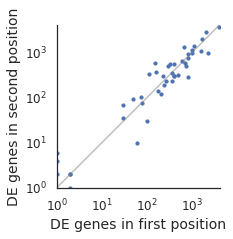

In [30]:
plot_comparison(downsampled_stats['de_genes_first'],
               downsampled_stats['de_genes_second'],
               'DE genes in first position',
               'DE genes in second position',
               log_scale=True,)
plt.savefig('./figures/performance_de_genes_by_position.pdf', bbox_inches='tight')

## Fold activation when guide is in position A or position B of cassette

regr:   y = 0.8903x + 0.0  (0.9911)
robust: y = 1.0216x + 0.0  (0.9665)
corr(x, y) = 0.9958
regr:   log y = 1.0053log x + 0.0  (0.9929)
robust: log y = 1.0128log x + 0.0  (0.9928)
corr(log x, log y) = 0.9965


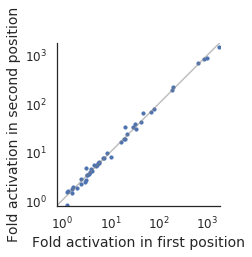

In [31]:
plot_comparison(mean_pop.cells.loc[guides_both_positions + '_NegCtrl0', 'fold_first_expr'],
                mean_pop.cells.loc['NegCtrl0_' + guides_both_positions, 'fold_second_expr'],
               'Fold activation in first position',
               'Fold activation in second position',
               log_scale=True, log_offset=0.001)
plt.savefig('./figures/performance_fold_activation_by_position.pdf', bbox_inches='tight')

## Number of differentially expressed genes vs. fold activation for all guides in position A of cassette

In [32]:
first_singles = mean_pop.cells.query('num_targets == 1 and second_target == "NegCtrl0"')
second_singles = mean_pop.cells.query('num_targets == 1 and first_target == "NegCtrl0"')
first_singles = first_singles[['fold_first_expr', 'ks_de']].replace({np.inf: np.nan}).dropna()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


Removing log 0 entries from log transformation
regr:   y = 0.4744x + 0.0  (-0.5236)
robust: y = 21.6477x + 0.0  (-163.4887)
corr(x, y) = 0.0724
regr:   log y = 1.4145log x + 0.0  (-2.3602)
robust: log y = 2.2740log x + 0.0  (-4.0432)
corr(log x, log y) = 0.1078


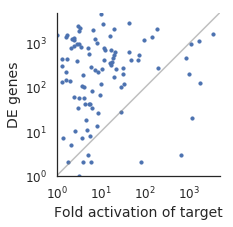

In [33]:
plot_comparison(first_singles['fold_first_expr'],
                first_singles['ks_de'],
               'Fold activation of target',
               'DE genes',
               log_scale=True,)
plt.savefig('./figures/performance_de_genes_vs_target_activation.pdf', bbox_inches='tight')